# Final Project Overview for Data Wrangling with MongoDB
## Data Wrangling OpenStreetMap Data of Upper West Side, Manhattan, New York City

The area I choose to look at is Upper West Side in the borough of Manhattan, New York City. The map data I am using is from [OpenStreetMap](https://www.openstreetmap.org/way/442560613#map=16/40.7779/-73.9249) which can be downloaded in XML format with the [Overpass API](http://overpass-api.de/api/map?bbox=-74.0227,40.7625,-73.9291,40.8111). 
I will apply the techniques learned from Udacity's [Data Wrangling with MongoDB](https://www.udacity.com/course/data-wrangling-with-mongodb--ud032) course to explore, audit and clean this dataset then convert the xml to JSON.

Upper West Side(UWS) is shown as the red bounded region below:

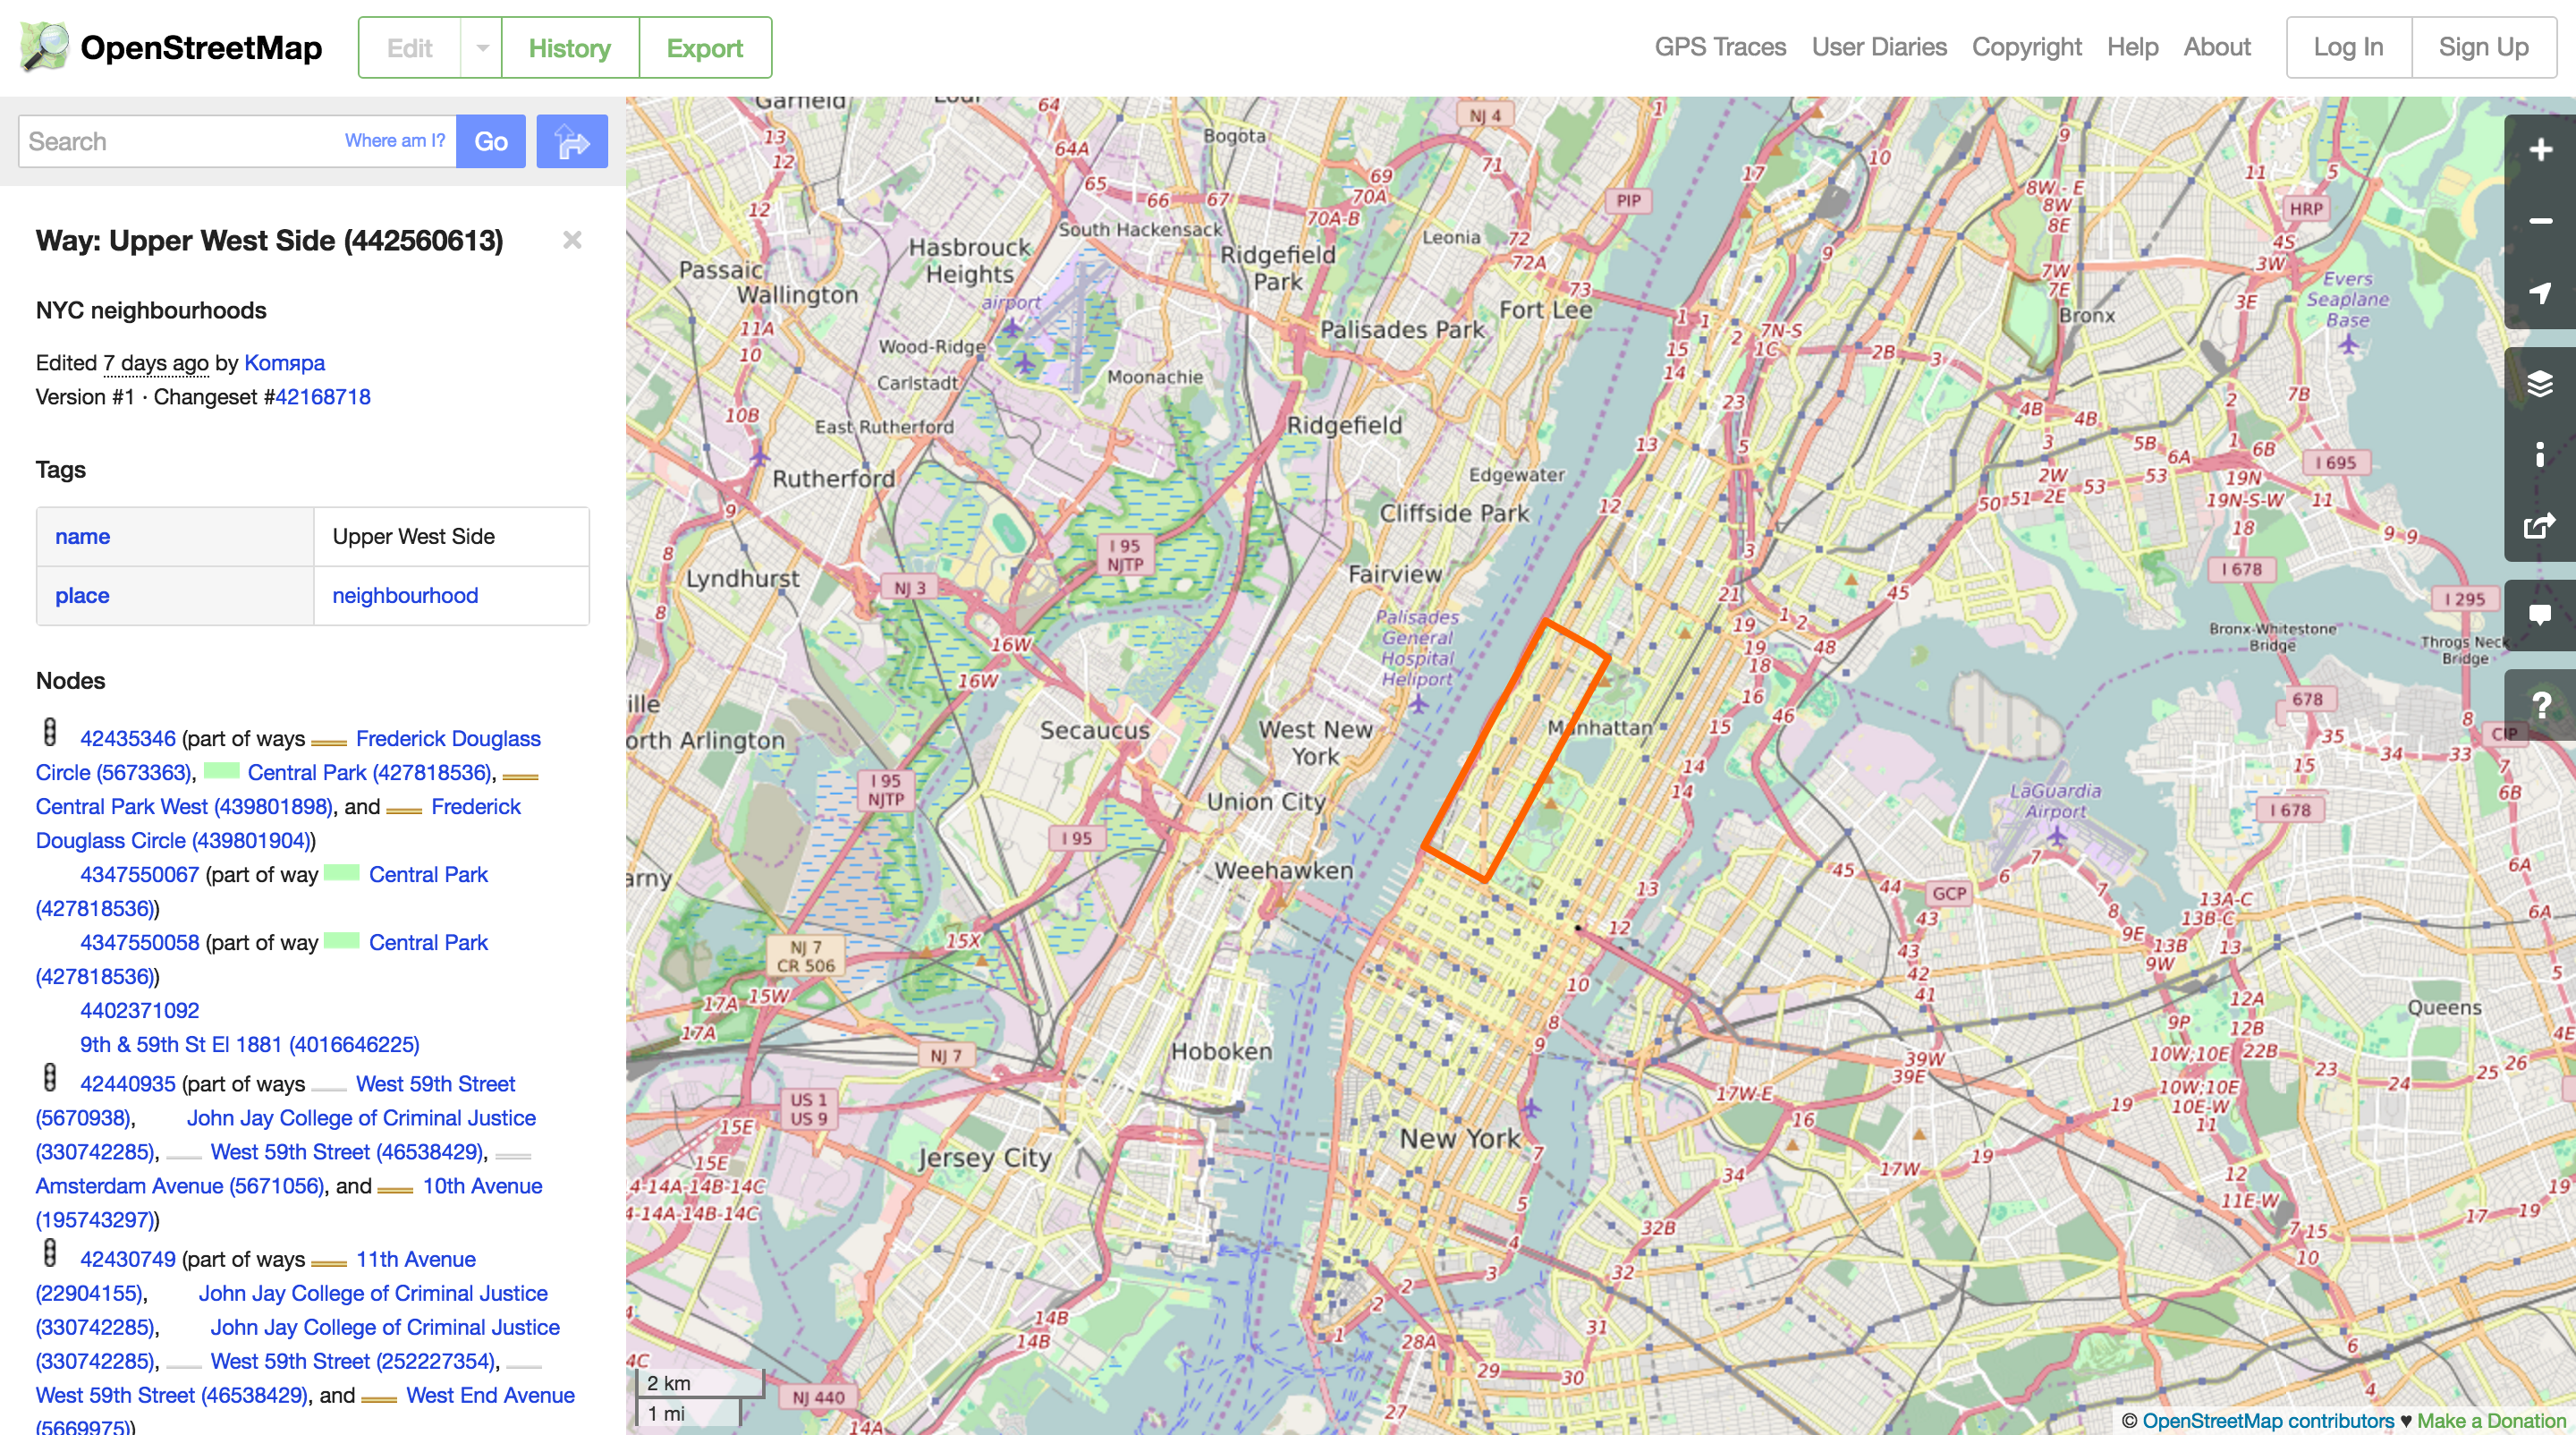

In [1]:
from IPython.display import Image
Image(filename='img/1.png') 

First, make sure the following libraries are imported.

In [2]:
import os
import os.path
import sys
import time
import requests
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
from collections import defaultdict
import bson
import pymongo


## Part I - Getting the Dataset

Let's download the map data using the Overpass API provided by OpenStreetMap. The function **`download_file()`** takes the url of the API and a filename you want to name your data, then downloads the map data to the current working diretory.

In [3]:
def download_file(api_url, local_filename):
    total_size = 57828278
    
    if os.path.exists(local_filename):
        if os.path.getsize(local_filename) == total_size:
            print 'Found and verified', local_filename
            return None

    r = requests.get(api_url, stream=True)
    with open(local_filename, 'wb') as f:
        print "Downloading %s" % local_filename, '...'
        
        dl_size = 0
        for chunk in r.iter_content(chunk_size=4096):
            if chunk:
                f.write(chunk)
                dl_size += len(chunk)
                done = int(100 * dl_size / float(total_size))
                sys.stdout.write("\r[%s%s]" % ('-' * done, ' ' * (100 - done)))    
                sys.stdout.flush()

    print '\nDownload finished. {} is ready.'.format(local_filename)

In [4]:
url = 'http://overpass-api.de/api/map?bbox=-74.0227,40.7625,-73.9291,40.8111'
osm_filename = 'data/uws_manhattan.osm'

download_file(url, osm_filename)

[--------------------------------------------------------------------------------------------------- ]
Download finished. data/uws_manhattan.osm is ready.


## Part II - Auditing the Data

Here's is an example of the OSM XML,
```xml
<node id="4407040193" lat="40.7940399" lon="-73.9494404" version="1" timestamp="2016-09-18T17:24:25Z" changeset="42252187" uid="1708831" user="blablubb1234">
    <tag k="addr:housenumber" v="1588"/>
    <tag k="addr:postcode" v="10029"/>
    <tag k="addr:street" v="Madison Avenue"/>
    <tag k="name" v="Uptown SuperMarket"/>
    <tag k="name:en" v="Uptown SuperMarket"/>
    <tag k="phone" v="212 828 0739"/>
    <tag k="shop" v="supermarket"/>
    <tag k="website" v="http://www.shopassociated.com"/>
  </node>
```

We want the database in the following format:

```json
{"_id": "4407040193",
 "created": {"version": "1",
             "timestamp": "2016-09-18T17:24:25Z",
             "changeset": "42252187",
             "uid": "1708831",
             "user": "blablubb1234"},
 "pos": [40.7940399, -73.9494404]
 "address": {"housenumber": "1588",
             "postcode": "10029",
             "street": "Madison Avenue"},
 "name": "Uptown SuperMarket",
 "phone": "212 828 0739",
 "shop": "supermarket",
 "website": "http://www.shopassociated.com"}
```

Before we add the dataset into the database, we need to check and see if there is any potential problems. 

As the first step of auditing the dataset, let's find out how many kinds of elements there are and  the occurrence of each element, to get the feeling on how much of which data we can expect to have in the map.

The function **`count_tags()`** takes a filename of a dataset and returns a dictionary with the tag name as the key and the occurrence of this tag as the value. 

In [5]:
def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename, events=('start', )):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

start_time = time.time()
tags = count_tags(osm_filename)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in tags.items()], reverse=True)]

print 'Element types and occurrence of uws_manhattan.osm:\n'
pprint.pprint(sorted_by_occurrence)

print('\n--- %s seconds ---' % (time.time() - start_time))

Element types and occurrence of uws_manhattan.osm:

[('nd', 297945),
 ('node', 222823),
 ('tag', 210173),
 ('way', 28516),
 ('member', 22074),
 ('relation', 706),
 ('osm', 1),
 ('note', 1),
 ('meta', 1),
 ('bounds', 1)]

--- 3.33348703384 seconds ---


Those elements that appear only once,
- `<bounds>`
- `<meta>`
- `<note>`
- `<osm>`

contain meta data of the osm file.


According to [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Elements), the following 3 elements,
- `<node>` (defining points in space),
- `<way>` (defining linear features and area boundaries), and
- `<relation>` (which are sometimes used to explain how other elements work together)

are the basic components of OpenStreetMap's conceptual data model of the physical world.



`<tag>` elements describe the meaning of the particular element to which they are attached by holding two free format text fields; a 'key' and a 'value'.

`<nd>` and `<member>` are child tags under `<way>` and `<relation>` respectively. They carry information that futher describe ways and relations.

Now let's take a look at the kinds of the attributes in the dataset. 

The function **`count_attrs()`** takes a filename of a dataset and returns a dictionary with the attribute name as the key and the occurrence of this attribute as the value.

In [6]:
def count_attrs(filename):
    attrs = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            for attr in elem.attrib:
                if attr not in attrs:
                    attrs[attr] = 1
                else:
                    attrs[attr] += 1
    return attrs

start_time = time.time()
attrs = count_attrs(osm_filename)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in attrs.items()], reverse=True)]

print 'Attributes and occurrence of uws_manhattan.osm:\n'
pprint.pprint(sorted_by_occurrence)

print('\n--- %s seconds ---' % (time.time() - start_time))

Attributes and occurrence of uws_manhattan.osm:

[('ref', 320019),
 ('version', 252046),
 ('user', 252045),
 ('uid', 252045),
 ('timestamp', 252045),
 ('id', 252045),
 ('changeset', 252045),
 ('lon', 222823),
 ('lat', 222823),
 ('v', 210173),
 ('k', 210173),
 ('type', 22074),
 ('role', 22074),
 ('osm_base', 1),
 ('minlon', 1),
 ('minlat', 1),
 ('maxlon', 1),
 ('maxlat', 1),
 ('generator', 1)]

--- 3.77912187576 seconds ---


The attributes we are most interested in are `k` and `v` which contain information of `<tag>` that describes the basic 3 elements.

Let's extract the values of `k` and find out how many kinds of `k` there are and the occurrence of each `k`.

In [7]:
def count_keys(filename):
    keys = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            key = elem.attrib.get('k')
            if key:
                if key not in keys:
                    keys[key] = 1
                else:
                    keys[key] += 1
    return keys

start_time = time.time()
keys = count_keys(osm_filename)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in keys.items()], reverse=True)]

print 'Keys and occurrence in uws_manhattan.osm:\n'
pprint.pprint(sorted_by_occurrence)

print('\n--- %s seconds ---' % (time.time() - start_time))

Keys and occurrence in uws_manhattan.osm:

[('addr:street', 24456),
 ('addr:housenumber', 24433),
 ('addr:postcode', 24272),
 ('height', 20938),
 ('building', 19743),
 ('nycdoitt:bin', 19396),
 ('highway', 7264),
 ('name', 6308),
 ('amenity', 2652),
 ('tiger:county', 2253),
 ('tiger:cfcc', 2245),
 ('tiger:name_base', 2054),
 ('tiger:name_type', 1936),
 ('roof:shape', 1921),
 ('tiger:reviewed', 1885),
 ('building:part', 1849),
 ('building:colour', 1845),
 ('roof:material', 1813),
 ('addr:city', 1623),
 ('oneway', 1570),
 ('tiger:zip_left', 1471),
 ('tiger:zip_right', 1364),
 ('addr:state', 1262),
 ('tiger:name_base_1', 944),
 ('hgv', 942),
 ('created_by', 902),
 ('building:material', 881),
 ('addr:country', 799),
 ('tiger:name_type_1', 796),
 ('website', 759),
 ('gnis:feature_id', 742),
 ('ele', 735),
 ('type', 706),
 ('capacity', 685),
 ('cityracks.street', 643),
 ('cityracks.small', 643),
 ('cityracks.rackid', 643),
 ('cityracks.large', 643),
 ('cityracks.housenum', 643),
 ('leisure',

As we can see there're 4 major formats of key values,
- lowercase letters with '\_', eg, 'access', 'admin_level',
- lowercase letters with ':', eg, 'addr: city', (the word after ':' is the secondary key),
- lowercase letter with '\.', eg, 'cityracks.housenum', and
- other

With 3 regular expressions, we check for certain patterns in the `<tag>` tags to see if we have any tags with
problematic characters.

The function **`key_type()`** returns a count of each of four tag categories in a dictionary:
- "lower", for tags that contain only lowercase letters and are valid,
- "lower_colon", for otherwise valid tags with a colon in their names,
- "lower_dot", for contains lowercase letters and dot


In [8]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
lower_dot = re.compile(r'^([a-z]|_)*.([a-z]|_)*$')


def key_type(element, keys):
    if element.tag == "tag":
        
        if lower.search(element.attrib['k']):
            keys['lower'] += 1
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon'] += 1
        elif lower_dot.search(element.attrib['k']):
            keys['lower_dot'] += 1
        else:
            keys['other'] += 1
        
    return keys


def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "lower_dot": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

In [9]:
start_time = time.time()
keys = process_map(osm_filename)

print 'Key types and occurrence in uws_manhattan.osm:'
pprint.pprint(keys)

print('\n--- %s seconds ---' % (time.time() - start_time))

Key types and occurrence in uws_manhattan.osm:
{'lower': 77749, 'lower_colon': 124625, 'lower_dot': 4141, 'other': 3658}

--- 3.78085803986 seconds ---


### Problem 1 - Out-of-Boundary Postcodes

Since the OpenStreetMap exports rectangular maps, the data sometimes includes points outside of the region we're interested. Postcodes used for upper west side are 10023, 10024 and 10025. When inspecting postcodes, some places outside of upper west side are also found in the dataset.

```xml
<node id="357745303" lat="40.7903787" lon="-74.0220844" version="5" timestamp="2014-12-17T20:28:49Z" changeset="27538394" uid="360392" user="maxerickson">
    <tag k="addr:city" v="West New York"/>
    <tag k="addr:housenumber" v="5808"/>
    <tag k="addr:postcode" v="07093"/>
    <tag k="addr:street" v="Kennedy Boulevard"/>
    <tag k="amenity" v="place_of_worship"/>
    <tag k="denomination" v="roman_catholic"/>
    <tag k="gnis:feature_id" v="2058600"/>
    <tag k="name" v="Our Lady of Libera Church"/>
    <tag k="phone" v="201-267-2642"/>
    <tag k="religion" v="christian"/>
    <tag k="website" v="http://home.catholicweb.com/libera/"/>
  </node>
```

Let's take a look at how many different postcodes there are and the occurrence of each one of them.

In [10]:
def count_postcodes(filename):
    postcodes = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            key = elem.attrib.get('k')
            if key == 'addr:postcode':
                postcode = elem.attrib.get('v')
                if postcode not in postcodes:
                    postcodes[postcode] = 1
                else:
                    postcodes[postcode] += 1
    return postcodes


start_time = time.time()

postcodes = count_postcodes(osm_filename)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in postcodes.items()], reverse=True)]

print 'Postcode values and occurrence in uws_manhattan.osm:\n'
pprint.pprint(sorted_by_occurrence)

print('\n--- %s seconds ---' % (time.time() - start_time))

Postcode values and occurrence in uws_manhattan.osm:

[('10025', 2515),
 ('10024', 2422),
 ('10029', 1942),
 ('10027', 1724),
 ('10021', 1716),
 ('10128', 1707),
 ('10023', 1700),
 ('10028', 1689),
 ('10035', 1605),
 ('10019', 1555),
 ('10065', 1453),
 ('10026', 1394),
 ('11106', 850),
 ('10075', 804),
 ('11102', 611),
 ('10037', 172),
 ('10036', 168),
 ('10022', 101),
 ('10454', 48),
 ('10069', 34),
 ('10451', 20),
 ('10044', 19),
 ('10115', 4),
 ('07093', 3),
 ('07086', 3),
 ('NY 10075', 2),
 ('83', 2),
 ('10153', 2),
 ('New York, NY 10065', 1),
 ('NY 10026', 1),
 ('10463', 1),
 ('10107', 1),
 ('07092', 1),
 ('07087', 1),
 ('07047', 1)]

--- 3.44881987572 seconds ---


Since we are interested in the upper west side area, we'll only keep elemets with postcodes 10023, 10024 and 10025.

Function **`get_postcode()`** takes an element and returns `True, postcode value` if the element contains a postcode, or `False, None` if the element doesn't contain a postcode.

Function **`clean_postcode()`** takes the original filename and a new filename, and returns a new file whose postcodes have been cleaned.

In [ ]:
def get_postcode(elem):
    if elem.tag in ['node', 'way', 'relation']:
        for tag in elem.iter():
            if tag.get('k') == 'addr:postcode':
                return True, tag.get('v')
        return False, None
    return False, None


def clean_postcode(filename, cleaned_filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for child in ['node', 'way', 'relation']:
        for elem in root.findall(child):
            has_postcode, postcode_value = get_postcode(elem)
            if has_postcode:
                if postcode_value not in ['10023', '10024', '10025']:
                    root.remove(elem)
    
    return tree.write(cleaned_filename)


start_time = time.time()

cleaned_postcode = 'data/cleaned_postcode.xml'
clean_postcode(osm_filename, cleaned_postcode)


print('\n--- %s seconds ---' % (time.time() - start_time))

Let's check if the cleaned xml file contains postcodes of 10023, 10024, and 10025 only.

In [ ]:
postcodes = count_postcodes(cleaned_postcode)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in postcodes.items()], reverse=True)]

print 'Postcode values and occurrence after cleaning:\n'
pprint.pprint(sorted_by_occurrence)

We've cleaned the postcode. The cleaned xml file is now **`cleaned_postcode.xml`**. We'll use this file as the input for next cleaning step.